2025-05-26 12:54:27.649039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748278467.662381 2923412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748278467.666459 2923412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 12:54:27.680916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
EigResult(eigenvalues=array([ 0.97748732+0.20338872j,  0.97748732-0.20338872j,
        0.99747795+0.06845214j,  0.99747795-0.06845214j,
        0.93847857+0.33255977j,  0.93847857-0.33255977j,
        0.8823121 +0.4525648j ,  0.8823121 -0.4525648j ,
        0.81157821+0.56061757j,  0.81157821-0.56061757j,
        0.72938638+0.65469867j,  0.72938638-0.65469867j,
        0.63912803+0.73363236j,  0.63912803-0.73363236j,
        0.54424006+0.79708647j,  0.54424006-0.79708647j,
        0.44799364+0.84550423j,  0.44799364-0.84550423j,
        0.35332638+0.87998357j,  0.35332638-0.87998357j,
        0.26272833+0.90212363j,  0.26272833-0.90212363j,
        0.17818406+0

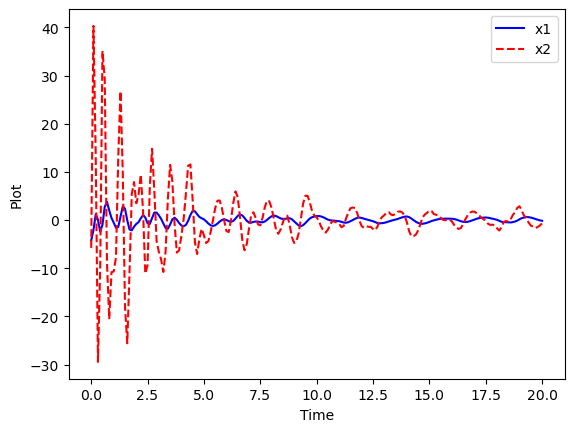

20100


In [1]:
#data generation for linear connected springs
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from numpy import linalg
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lti, dlti, dstep
import scipy.integrate
import time
from mpl_toolkits import mplot3d
import matplotlib
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset  

print(tf.config.list_physical_devices())
start=time.time()

# Simulation variables
seq_length = 201 # Number of time steps in each sequence
num_records = 100 # Number of sequences to generate
dim_y =20 # Degrees of freedom (number of connected masses) # No. of measured states
dim_x= 2*dim_y # Number of states

# Arrays to store results
X_data_array = np.empty((num_records, seq_length, dim_x))
Y_data_array = np.empty((num_records, seq_length, dim_y))

# Continuous-time model
# Parameters 

# Masses (kg)
m = np.ones(dim_y)
m = 10*m

# Spring constants (N/m)
k = np.ones(dim_y)
k = 800*k

# Damping factors (Ns/m)
d = np.ones(dim_y)
d = 6*d

# State-space
A_c = np.zeros((dim_x,dim_x))

offset = 0
for i in range(dim_x):
    if i % 2 == 0:
        A_c[i,i+1] = 1

    if i % 2 == 1:
        if i != dim_x-1:
            A_c[i,i-1] = -(k[i-1-offset]+k[i-offset])/m[i-1-offset]
            A_c[i,i] = -(d[i-1-offset]+d[i-offset])/m[i-1-offset]
            A_c[i,i+1] = k[i-offset]/m[i-1-offset]
            A_c[i,i+2] = d[i-offset]/m[i-1-offset]
        else:
            A_c[i,i-1] = -k[i-dim_y]/m[i-dim_y]
            A_c[i,i] = -d[i-dim_y]/m[i-dim_y]

        if i != 1:
            A_c[i,i-3] = k[i-1-offset]/m[i-1-offset]
            A_c[i,i-2] = d[i-1-offset]/m[i-1-offset]
        
        offset += 1

B_c = np.zeros((dim_x,dim_y))

H_c = np.zeros((dim_y,dim_x))
offset = 0
for i in range(dim_y):
    H_c[i,i+offset] = 1

    offset += 1

D_c = np.array([[0.]])

# Discretize LTI system using zero-order hold method
dt = 0.1 # Sampling time (seconds)
d_system = cont2discrete((A_c, B_c, H_c, D_c),dt)
A = d_system[0] # Process matrix
H = d_system[2] # Measurement matrix`
print(np.linalg.eig(A))
print(A)

def is_schur(matrix):
    # Check eigenvalues
    eigenvalues, _ = np.linalg.eig(matrix)
    if np.all(np.abs(eigenvalues) < 1):
        print(np.abs(eigenvalues))
        return True
    else:
        return False
    
if is_schur(A):
    print("The matrix is Schur.")
else:
    print("The matrix is not Schur.")
    
# Noise parameters
sigma_p = 0.01 # Standard deviation of process noise
sigma_p_diag = (sigma_p**2)*np.ones(dim_x)
Q = np.diag(sigma_p_diag)

sigma_m = 0.01 # Standard deviation of measurement noise
sigma_m_diag = (sigma_m**2)*np.ones(dim_y)
R = np.diag(sigma_m_diag)

sigma_x = 0.01 # Standard deviation of initial state
sigma_x_diag = (sigma_p**2)*np.ones(dim_x)
P = np.diag(sigma_x_diag)

# Simulation
for s in range(num_records):
    mu_x0 = np.random.uniform(-10,10,size=dim_x) # Initial true state
    x=np.random.multivariate_normal(mu_x0,P)
    # Store initial values
    X_data_array[s,0,:] = np.squeeze(np.asarray(x))

    # Get initial measurement noise
    v_0 = np.random.multivariate_normal(np.zeros(dim_y),R).reshape(-1,1)
    
    y = H.dot(x.reshape(-1,1)) + v_0 # Initial measurement


    W = np.random.multivariate_normal(np.zeros(dim_x), Q, seq_length)
    V = np.random.multivariate_normal(np.zeros(dim_y), R, seq_length)
    Y_data_array[s,0,:] = np.squeeze(np.asarray(y)) # Record initial measurement
    
    for t in range(1,seq_length+1):
        w = W[t-1].reshape(-1,1) # Process noise at time t
        v = V[t-1].reshape(-1,1) # Measurement noise at time t
       # u = U[t-1].reshape(-1,1) # Input at time t

        #x = A.dot(x)+B.dot(u) + w # State at time t
        x = A.dot(x.reshape(-1,1)) + w 
        y = H.dot(x.reshape(-1,1)) + v # Measurement at time t
         
        X_data_array[s,t:t+1,:] = x.T # Store true state at time t
        Y_data_array[s,t:t+1,:] = y.T # Store measurement at time t

end_t=seq_length*dt
t_span=np.arange(0,end_t,dt)
plt.plot(t_span,X_data_array[0,:,0],'b-',label='x1')
plt.plot(t_span,X_data_array[0,:,1],'r--',label='x2')
plt.ylabel('Plot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

num_data_pts=seq_length*num_records
print(num_data_pts)

num_train_pts=np.floor(0.80*num_records).astype(int)
num_val_pts=np.floor(0.10*num_records).astype(int)
test_data_size=num_records-num_train_pts-num_val_pts

Y_train=Y_data_array[0:num_train_pts,:,:]
X_train=X_data_array[0:num_train_pts,:,:]
num_train_plus_val=num_train_pts+num_val_pts

Y_validate=Y_data_array[num_train_pts:num_train_plus_val,:,:]
X_validate=X_data_array[num_train_pts:num_train_plus_val,:,:]

Y_test=Y_data_array[num_train_plus_val:num_records,:,:]
X_test=X_data_array[num_train_plus_val:num_records,:,:]

np.savez("connected_springs_data.npz", X_data=X_data_array, Y_data=Y_data_array)

In [2]:
X_data_array_diff_ic = np.empty((num_records, seq_length, dim_x))
Y_data_array_diff_ic = np.empty((num_records, seq_length, dim_y))

for s in range(num_records):
    mu_x0 = np.random.uniform(-20,20,size=dim_x) # Initial true state
    x=np.random.multivariate_normal(mu_x0,P)
    # Store initial values
    X_data_array_diff_ic[s,0,:] = np.squeeze(np.asarray(x))

    # Get initial measurement noise
    v_0 = np.random.multivariate_normal(np.zeros(dim_y),R).reshape(-1,1)
    
    y = H.dot(x.reshape(-1,1)) + v_0 # Initial measurement


    W = np.random.multivariate_normal(np.zeros(dim_x), Q, seq_length)
    V = np.random.multivariate_normal(np.zeros(dim_y), R, seq_length)
    Y_data_array_diff_ic[s,0,:] = np.squeeze(np.asarray(y)) # Record initial measurement
    
    for t in range(1,seq_length+1):
        w = W[t-1].reshape(-1,1) # Process noise at time t
        v = V[t-1].reshape(-1,1) # Measurement noise at time t
       # u = U[t-1].reshape(-1,1) # Input at time t

        #x = A.dot(x)+B.dot(u) + w # State at time t
        x = A.dot(x.reshape(-1,1)) + w 
        y = H.dot(x.reshape(-1,1)) + v # Measurement at time t
         
        X_data_array_diff_ic[s,t:t+1,:] = x.T # Store true state at time t
        Y_data_array_diff_ic[s,t:t+1,:] = y.T # Store measurement at time t

np.savez("connected_springs_data_diff_ic.npz", X_data=X_data_array_diff_ic, Y_data=Y_data_array_diff_ic)

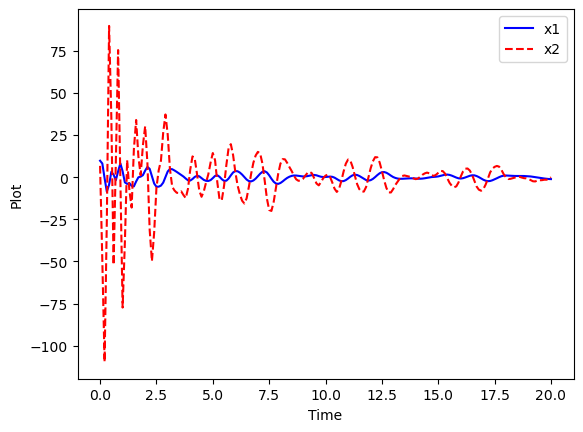

In [3]:
plt.plot(t_span,X_data_array_diff_ic[0,:,0],'b-',label='x1')
plt.plot(t_span,X_data_array_diff_ic[0,:,1],'r--',label='x2')
plt.ylabel('Plot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()